# **AI in Medicine**
## Decision Trees, and Neural Networks

Welcome to the third programming workshop for the AI in Medicine series! 

Today we will be diving into some more advanced concepts in machine learning:
*    Supervised learning: Decision Trees and understanding Overfitting
*    Cross-validation

Before you begin reading and editing any code, make sure to make a personal copy of this notebook by clicking `File` --> `Save a Copy in Drive` so you can make changes to the code.

## Imports and loading the dataset


In [1]:
# Load the necessary python libraries
from sklearn import preprocessing, decomposition
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_wine, load_breast_cancer
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import graphviz
from graphviz import Source
from IPython.display import SVG
import pandas as pd
import numpy as np
import scipy

%matplotlib inline
plt.style.use('bmh')
plt.rcParams.update({'font.size': 14,
                     'xtick.labelsize' : 14,
                     'ytick.labelsize' : 14,
                     'figure.figsize' : [12,8],
                     })

# **Supervised Learning**: Decision Trees for Classification

This session we will look at another supervised learning technique, Decision Trees. Recall that last session we looked at logistic regression, which is suitable for classifying data that is *linearly separable*. Decision trees, on the other hand, can learn non-linear classification boundaries which is suitable for more complex datasets. Another benefit of decision trees is that they are **easy to interpret**! This is because, for a trained decision tree classifier, you can directly view the decisions that are being made in the algorithm which lead to the final classification. As a result, decision trees are a great option for medical problems (such as reaching a diagnosis based on certain patient symptoms) where it is important to explain and understand how an algorithm reaches its decision.

Once again, we will be analyzing the breast cancer dataset. We will use decision trees to learn how to predict benign from malignant tumors, and we will investigate how the accuracy changes as we change the depth of the decision tree.

**Reminder:** the breast cancer dataset has 539 tumor cases with 30 features each. Feel free to visualize and plot the features to explore the data

In [2]:
# Load breast cancer dataset and store as a Pandas dataframe. This code is the same as used in the previous session
cancer = load_breast_cancer()
scaler = preprocessing.StandardScaler().fit(cancer.data) # Define a scaler which standardizes the data to have mean 0 and standard devation 1. This usually improves stability and performance
cancer_data_scaled = scaler.transform(cancer.data) #Use the scaler to transform the training and test data

## Training a decision tree and understanding overfitting:

`sklearn` provides all the code necessary to create and train a decision tree. 

One of the most important parameters that we need to settle on for a decision tree is its maximum depth, which is essentially how many levels of decisions we want the algorithm to make before arriving at the final classification. If we pick a decision tree with too few levels (e.g. `max_depth = 1`), then it will not be complex enough to accurately differentiate between benign and malignant tumors. On the other hand, if our decision tree has too many levels (e.g. `max_depth = 15` for our dataset), then the algorithm will try to perfectly classify the training set over 15 levels of questions. The issue here is that this perfect classification will not generalize to the validation set, and so the validation accuracy will be poor. We will do a simple experiment to figure out how to pick the appropriate decision tree depth, and you can use this type of analysis in the future to settle on other important parameters for algorithms.

This will be our experiment:
1.  Split the dataset into training and validation sets with a split of 75%/25%
2.  Train 15 different decision tree classifiers with exactly the same parameters, with the exception of maximum depth which varies from 1 to 15. 
3.  Visualize training and validation set accuracy for each decision tree
4.  Visualize the decision tree with the most appropriate maximum depth
5. Visualize the best decision tree results as a confusion matrix



In [3]:
# This is an important hyperparameter which determines how the training and validation data is split.
# Try changing it to another integer and rerunning the max_depth experiment below.
random_state = 13

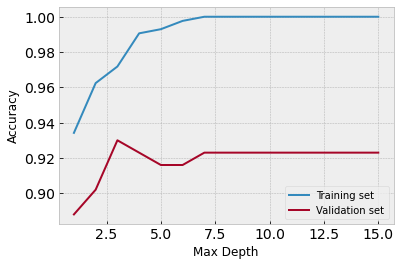

In [4]:
# Split the dataset into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(cancer_data_scaled, cancer.target, random_state=random_state)

# Create empty variables to store the decision tree accuracy results
training_accuracy = []
validation_accuracy = []

# Define the range of decision tree as 1 - 15
max_dep = range(1,16)

# Use a for loop to try each of the maximum depth decision trees, and store the scores in the appropriate lists
for md in max_dep:
    tree = DecisionTreeClassifier(max_depth=md,random_state=0)
    tree.fit(X_train,y_train)
    training_accuracy.append(tree.score(X_train, y_train))
    validation_accuracy.append(tree.score(X_validation, y_validation))

# Plot the tree depths against training and validation set accuracies
plt.figure()
plt.plot(max_dep,training_accuracy, label='Training set')
plt.plot(max_dep,validation_accuracy, label='Validation set')
plt.ylabel('Accuracy')
plt.xlabel('Max Depth')
plt.legend()
plt.show()


## What is the optimal tree depth?
## Can you explain why the training set accuracy keeps increasing with depth?

The training accuracy is:  0.971830985915493
The validation accuracy is:  0.9300699300699301


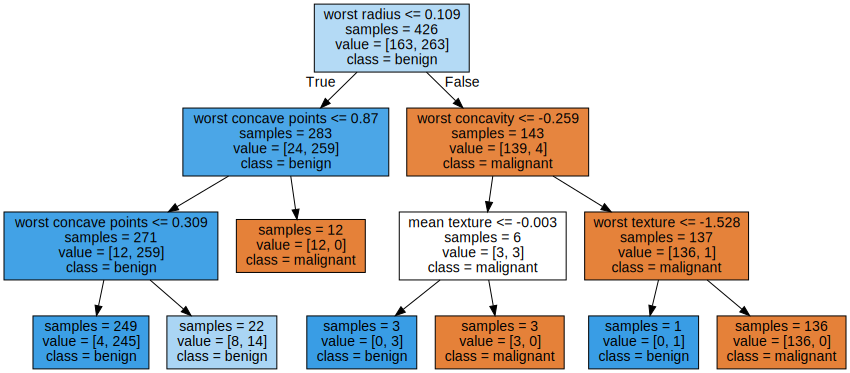

In [5]:
# By looking at the above accuracy plot, the best validation accuracy is when max_depth is 3. 
# Above this value, the model isn't as accurate on the validation set.
# Let's re-train the tree with max_depth = 3

max_depth = 3

tree = DecisionTreeClassifier(max_depth=max_depth,random_state=0)
tree.fit(X_train,y_train)
training_accuracy = tree.score(X_train, y_train)
validation_accuracy = tree.score(X_validation, y_validation)
print('The training accuracy is: ', training_accuracy)
print('The validation accuracy is: ', validation_accuracy)

# Visualize decision tree
graph = Source(export_graphviz(tree, out_file=None, class_names=['malignant','benign'], feature_names=cancer.feature_names, impurity=False, filled=True))
SVG(graph.pipe(format='svg'))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


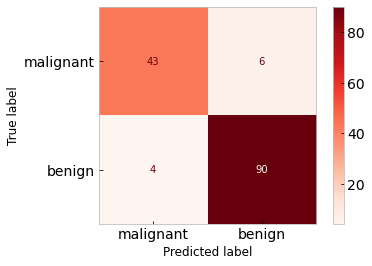

In [6]:
# Visualize results as a confusion matrix
fig, ax = plt.subplots()
plot_confusion_matrix(tree, X_validation, y_validation,
                       display_labels=['malignant','benign'],
                                cmap=plt.cm.Reds,ax=ax)
plt.grid(False)
plt.show()

From our little experiment, we can see that a **maximum depth greater than 3 results in an overfitted model**. We can also see from the top level of the decision tree itself that the most important feature in the dataset by which to sort tumor classes is the 'worst radius' feature.

# **Supervised Learning:** Cross-validation
**Do you feel that our above experiment was conclusive enough? Are you 100% certain that the best value of maximum depth is 3, and that the most discriminative feature really is worst radius?**

You may have realized that the maximum depth selection process is sensitive to how the data is split into the training and validation sets. What if we repeated the training/validation split so there were different samples in each of the sets? You can try this by changing the `random_state` above from `13` to another number (in the line `X_train, X_validation, y_train, y_validation = train_test_split(..., random_state=13)`

However, a more systematic way of seeing how different training/validation splits affects the overall analysis is by performing cross-validation. Here you split the data into $n$ different 'folds' so that in each fold the data in training and validation is different. The diagram below visualizes this concept - the top is what we did above and the grid is showing '5-fold cross-validation'


<img src=https://scikit-learn.org/stable/_images/grid_search_cross_validation.png>

We will do a second experiment now using a 5-fold cross validation. We will vary maximum depth between 1 and 15 as before, but we will try each maximum depth for each of 5 different training/validation folds. Therefore we should expect $15$ max_depths $\times5$ folds $=75$ accuracies for the training and validation set each.

Luckily for us, the `sklearn` library also provides a `cross_validate` function to create cross-validation splits, so we don't have to manually code that.

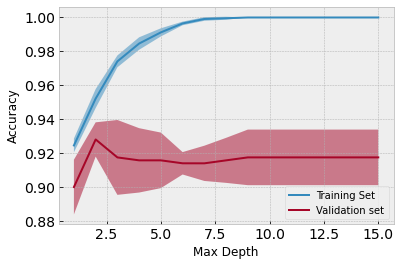

In [7]:
# Create empty variables to store the decision tree accuracy results
training_accuracy = []
validation_accuracy = []
scoring={'accuracy'}

# Define the range of decision tree depths you want to train
max_dep = range(1,16)

# Use a for loop to test each of the 15 maximum depth settings in the decision tree.
# *NOTE* This time we use the `cross_validate` function to get 5 results on the training and validation fold for each maximum depth!
for md in max_dep:
    tree = DecisionTreeClassifier(max_depth=md,random_state=0)
    results = cross_validate(tree, cancer_data_scaled, cancer.target, cv=5, scoring=scoring, return_train_score=True)
    training_accuracy.append(results['train_accuracy'])
    validation_accuracy.append(results['test_accuracy'])

# Now the train_accuracy and validation_accuracy lists contain 15 different lists, each with 5 accuracy values for each fold.
# Let's visualize all this information in the same line plot, by plotting the mean accuracies for each maximum depth +/- the standard deviations
training_acc_mean = np.mean(training_accuracy, axis=1)
training_acc_std = np.std(training_accuracy, axis=1)
val_acc_mean = np.mean(validation_accuracy, axis=1)
val_acc_std = np.std(validation_accuracy, axis=1)

plt.figure()
plt.plot(max_dep, training_acc_mean, label='Training Set')
plt.fill_between(max_dep, training_acc_mean-training_acc_std, training_acc_mean+training_acc_std, alpha=0.5)
plt.plot(max_dep, val_acc_mean, label='Validation set')
plt.fill_between(max_dep, val_acc_mean-val_acc_std, val_acc_mean+val_acc_std, alpha=0.5)
plt.ylabel('Accuracy')
plt.xlabel('Max Depth')
plt.legend(loc='lower right')
plt.show()

**Using 5-fold cross validation, we can come to a better conclusion that perhaps a max-depth of 2 is more appropriate as the absolute mean validation accuracy is higher. However, as you can see there is a significant error (standard deviation) so this difference is not necessarily statistically significant.**

Feel free to play around with a different number cross-validation folds (adjusted using the `cv` input keyword to the `cross_validate` function), and different random states for the decision tree classifier. Also feel free to plot the best decision tree to see which features are the most important.

You can read more about [Decision Trees](https://scikit-learn.org/stable/modules/tree.html) and [Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html) on the scikit-learn website.